# Import Dependencies

In [23]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

from torchvision import transforms, models, datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve,f1_score
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from PIL import Image,ImageFile , UnidentifiedImageError
import pandas as pd
from dataclasses import dataclass
import seaborn as sn

from PIL import Image,ImageFile , UnidentifiedImageError
#%matplotlib inline

### Set seed for reproducibilty

In [24]:
def set_seed(seed):
    random.seed(seed)  # Set the seed for Python's built-in random module
    np.random.seed(seed)  # Set the seed for NumPy's random number generator
    torch.manual_seed(seed)  # Set the seed for PyTorch's random number generator

    if torch.cuda.is_available():  # Check if a CUDA-enabled GPU is available
       torch.cuda.manual_seed(seed)  # Set the seed for CUDA (single GPU)
       torch.cuda.manual_seed_all(seed)  # Set the seed for CUDA (multiple GPUs)
       torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CuDNN
       torch.backends.cudnn.benchmark = True  # Enable benchmark mode for CuDNN (can improve performance)

set_seed(42)  # Set the random seed to 42 for reproducibility

# Dataset and Training Configuration Parameters

In [25]:
@dataclass(frozen=True)
class TrainingConfig:
    batch_size: int = 32
    num_epochs: int = 32
    learning_rate: float = 1e-4
    num_workers: int = 2

train_config = TrainingConfig()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


# Creation of an adapted FraiseDataset class

In [26]:
ImageFile.LOAD_TRUNCATED_IMAGES = True  # pour éviter les erreurs d'images corrompues
class FraiseDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations.columns = ['image', 'label']
        self.annotations['label'] = self.annotations['label'].apply(
            lambda x: eval(x)[0] if isinstance(x, str) and x.startswith('[') else int(x)
        )
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        try:
            row = self.annotations.iloc[idx]
            img_path = os.path.join(self.image_dir, row['image'])
            label = row['label']

            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label

        except (FileNotFoundError, UnidentifiedImageError) as e:
            # Skip image by trying the next one (wrap around if needed)
            new_idx = (idx + 1) % len(self)
            return self.__getitem__(new_idx)


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Load datasets with ResNet-style transforms

In [27]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = FraiseDataset(csv_file='../Data/train_labels.csv', image_dir='../Data/Fraises', transform=transform_train)
val_dataset = FraiseDataset(csv_file='../Data/val_labels.csv', image_dir='../Data/Fraises', transform=transform_val)
test_dataset = FraiseDataset(csv_file='../Data/test_labels.csv', image_dir='../Data/Fraises', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=train_config.batch_size, shuffle=False)

/home/lechat/miniconda3/envs/projet/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Dataset Preprocessing

## Fine-tuning with Pretrained Model

In [28]:
model = models.resnet18(weights="DEFAULT")
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(DEVICE)

optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=train_config.learning_rate)

fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 4),  # 4 classes de fraises
    nn.LogSoftmax(dim=1)
)

model = model.to(DEVICE)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

## Map classes

In [29]:
class_mapping = {
    0: "non-mûr",
    1: "semi-mûr",
    2: "presque-mûr",
    3: "mûr"
}

## Display Sample Images from the Dataset

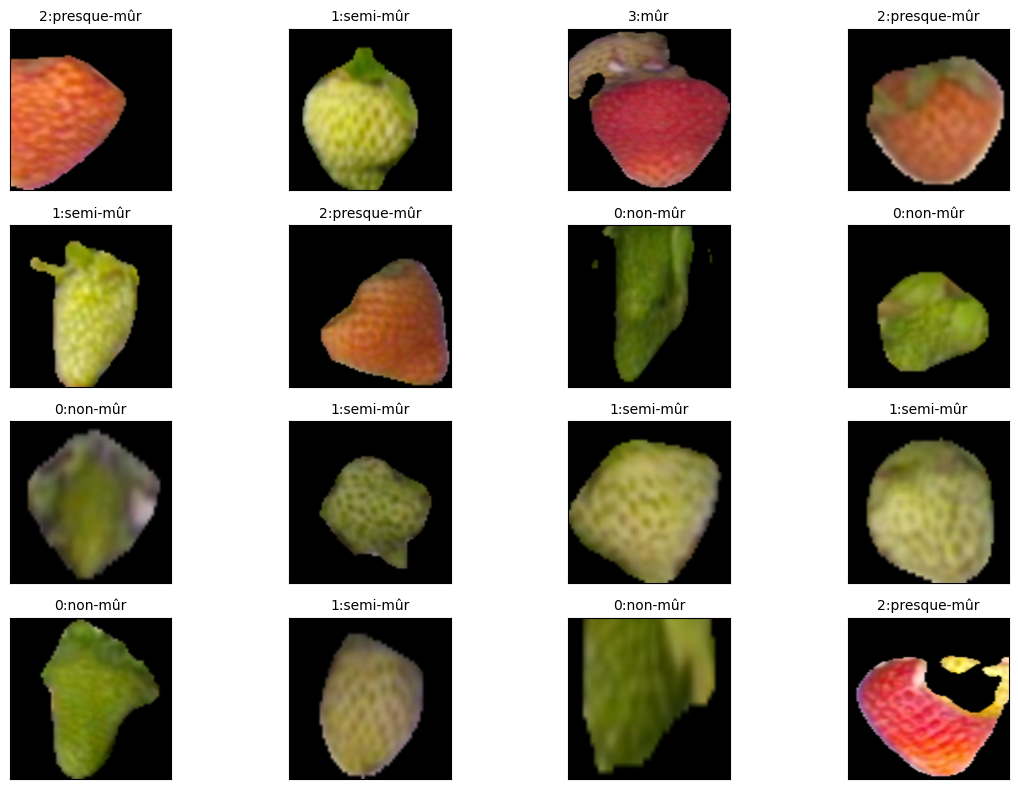

In [31]:
def visualize_images(dataloader, class_mapping, num_images=16):
    fig = plt.figure(figsize=(12, 8))
    images, labels = next(iter(dataloader))

    num_cols = 4
    num_rows = int(np.ceil(num_images / num_cols))

    for i in range(min(num_images, len(images))):
        image = images[i].permute(1, 2, 0).numpy()
        image = np.clip(image * np.array(std) + np.array(mean), 0, 1)
        label = labels[i].item()

        ax = fig.add_subplot(num_rows, num_cols, i+1, xticks=[], yticks=[])
        ax.imshow(image)
        ax.set_title(f"{label}:{class_mapping[label]}", fontsize=10)

    plt.tight_layout()
    plt.show()

visualize_images(train_loader, class_mapping, num_images=16)

# Model Training and Evaluation

In [32]:
def train(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (output.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / len(loader), 100 * correct / total

In [33]:
def validate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x)
            loss = F.cross_entropy(output, y)

            total_loss += loss.item()
            correct += (output.argmax(1) == y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), 100 * correct / total

## Training loop

In [34]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_acc = 0.0
model = model.to(DEVICE)

for epoch in range(train_config.num_epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.2f}, Train Acc {train_acc:.2f}% | Val Loss {val_loss:.2f}, Val Acc {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model_resnet18.pt")

Epoch 1: Train Loss 0.64, Train Acc 82.53% | Val Loss 0.30, Val Acc 92.39%
Epoch 2: Train Loss 0.32, Train Acc 92.21% | Val Loss 0.26, Val Acc 93.45%
Epoch 3: Train Loss 0.25, Train Acc 95.02% | Val Loss 0.24, Val Acc 92.60%
Epoch 4: Train Loss 0.22, Train Acc 95.34% | Val Loss 0.22, Val Acc 93.45%
Epoch 5: Train Loss 0.18, Train Acc 96.42% | Val Loss 0.22, Val Acc 93.23%
Epoch 6: Train Loss 0.15, Train Acc 97.60% | Val Loss 0.24, Val Acc 93.02%
Epoch 7: Train Loss 0.15, Train Acc 98.10% | Val Loss 0.23, Val Acc 92.81%
Epoch 8: Train Loss 0.13, Train Acc 99.14% | Val Loss 0.22, Val Acc 92.81%
Epoch 9: Train Loss 0.12, Train Acc 98.87% | Val Loss 0.25, Val Acc 91.33%
Epoch 10: Train Loss 0.11, Train Acc 99.37% | Val Loss 0.22, Val Acc 93.02%
Epoch 11: Train Loss 0.10, Train Acc 99.28% | Val Loss 0.22, Val Acc 94.08%
Epoch 12: Train Loss 0.09, Train Acc 99.68% | Val Loss 0.22, Val Acc 92.81%
Epoch 13: Train Loss 0.08, Train Acc 99.77% | Val Loss 0.25, Val Acc 92.60%
Epoch 14: Train Loss 

# Displaying graphs

## Accuracy graph

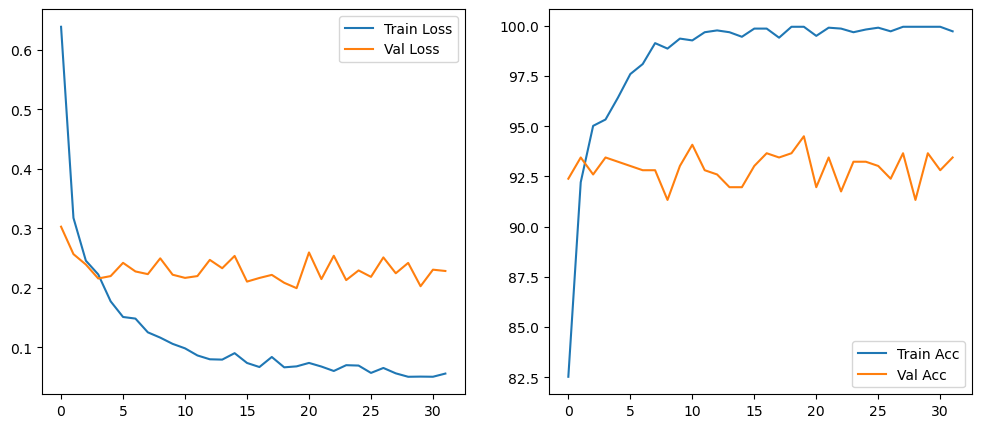

In [35]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.show()


## ROC graph

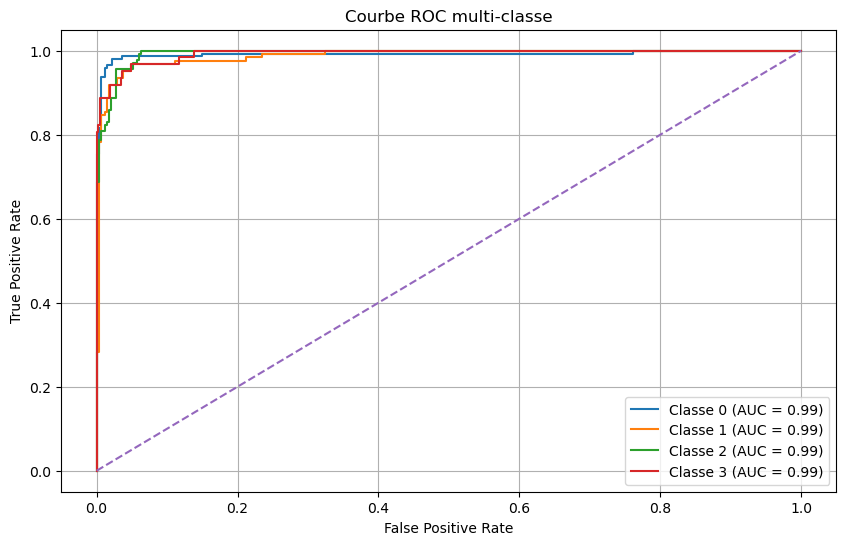

In [36]:
model.load_state_dict(torch.load("best_model_resnet18.pt"))
model.eval()
num_classes = len(class_mapping)
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        outputs = model(x)
        probs = F.softmax(outputs, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

# ROC (multiclasse - one vs rest)
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], np.array(y_prob)[:, i])

# Tracer la courbe ROC
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Classe {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Courbe ROC multi-classe")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

In [37]:
def compute_test_accuracy(model, test_loader):
    model.eval()
    model.to(DEVICE)

    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(test_loader, desc="Test"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

            # Stocke pour le F1
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')  

    print(f" Test Accuracy: {acc:.2f}%")
    print(f" F1-score (weighted): {f1:.2f}")

model.load_state_dict(torch.load("best_model_resnet18.pt"))
compute_test_accuracy(model, test_loader)

Test: 100%|█████████████████████████████████████| 15/15 [00:01<00:00, 12.58it/s]

✅ Test Accuracy: 94.51%
🎯 F1-score (macro): 0.95


# Inference

In [38]:
def prediction(model, val_loader):
    """
    Generates predictions using the trained model on validation data.

    Returns:
        - images: np.ndarray (N, 3, H, W)
        - labels: np.ndarray (N,)
        - predicted class indices
        - predicted confidence scores
    """
    model.eval()
    model.to(DEVICE)

    all_images, all_labels = [], []
    all_pred_indices, all_pred_probs = [], []

    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.inference_mode():
            outputs = model(images)

        prob = F.softmax(outputs, dim=1)
        pred_indices = prob.data.max(dim=1)[1]
        pred_probs = prob.data.max(dim=1)[0]

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_pred_indices.append(pred_indices.cpu())
        all_pred_probs.append(pred_probs.cpu())

    return (
        torch.cat(all_images).numpy(),
        torch.cat(all_labels).numpy(),
        torch.cat(all_pred_indices).numpy(),
        torch.cat(all_pred_probs).numpy()
    )

## Visualize predictions

In [39]:
def denormalize(image):
    mean_ar = np.array(mean)
    std_ar = np.array(std)
    return np.clip(image * std_ar + mean_ar, 0, 1)

def visualise_predictions(sample_images, sample_gt_labels, pred_indices, pred_probs, class_mapping, num_images=16):
    fig = plt.figure(figsize=(16, 8))

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) - 1)
        image = sample_images[idx].transpose(1, 2, 0)
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]

        image = denormalize(image)
        color = "green" if label == pred_idx else "red"

        ax = fig.add_subplot(4, 4, i + 1)
        ax.imshow(image)
        ax.set_title(
            f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob*100:.1f}%)",
            color=color,
            fontsize=9
        )
        ax.axis('off')

    plt.tight_layout()
    plt.show()


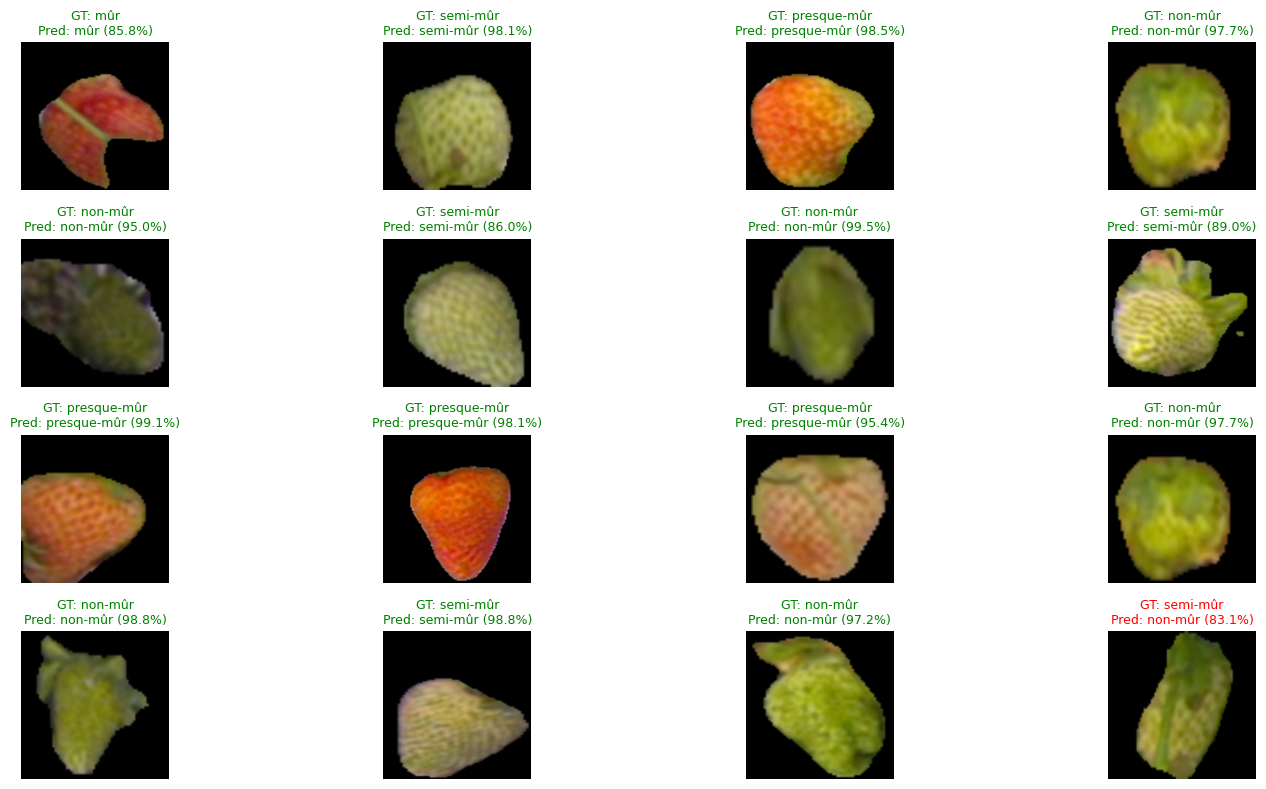

In [40]:
# Génère toutes les prédictions
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)

# Affiche la grille de résultats
visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, class_mapping, num_images=16)


## Confusion matrix

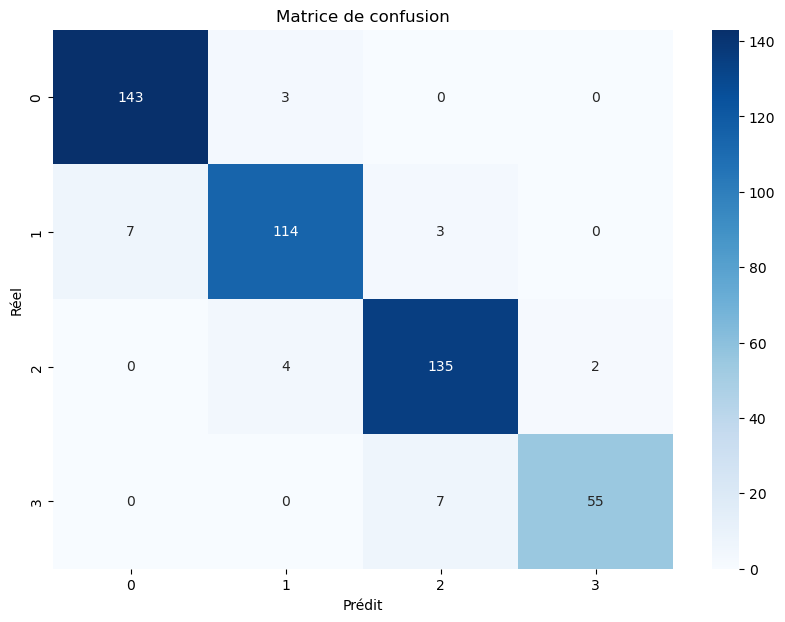

In [41]:
idx_to_class = {v: k for k, v in class_mapping.items()}

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()